# 保险赔偿预测模型的建立

<img src="images/1.png" alt="FAO" width="590" >

导入模块

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from copy import deepcopy

EDA(数据探索分析)

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [5]:
train.shape

(188318, 132)

In [6]:
train.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


In [8]:
#我们看到，大概有116个种类属性（如它们的名字所示）和14个连续（数字）属性。 此外，还有ID和赔偿。总计为132列。
#且数据已经预处理好了

In [9]:
pd.isnull(train).values.any()

False

In [10]:
#没有缺失值，省去一道步骤

In [12]:
train.info(max_cols=150) #详细数据类型展示

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Data columns (total 132 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      188318 non-null  int64  
 1   cat1    188318 non-null  object 
 2   cat2    188318 non-null  object 
 3   cat3    188318 non-null  object 
 4   cat4    188318 non-null  object 
 5   cat5    188318 non-null  object 
 6   cat6    188318 non-null  object 
 7   cat7    188318 non-null  object 
 8   cat8    188318 non-null  object 
 9   cat9    188318 non-null  object 
 10  cat10   188318 non-null  object 
 11  cat11   188318 non-null  object 
 12  cat12   188318 non-null  object 
 13  cat13   188318 non-null  object 
 14  cat14   188318 non-null  object 
 15  cat15   188318 non-null  object 
 16  cat16   188318 non-null  object 
 17  cat17   188318 non-null  object 
 18  cat18   188318 non-null  object 
 19  cat19   188318 non-null  object 
 20  cat20   188318 non-null  object 
 21  cat21   1

In [37]:
import collections
cat_features = list(train.select_dtypes(include=['object']).columns)
cat_uniques = []
for cat in cat_features:
    cat_uniques.append(len(train[cat].unique()))
    
uniq_values_in_categories = pd.DataFrame.from_dict(collections.OrderedDict([('cat_name', cat_features), ('unique_values', cat_uniques)]))

In [39]:
uniq_values_in_categories.head() #查看类别值属性的个数

,cat_name,unique_values
0,cat1,2
1,cat2,2
2,cat3,2
3,cat4,2
4,cat5,2


Text(7, 71, 'Binary features')

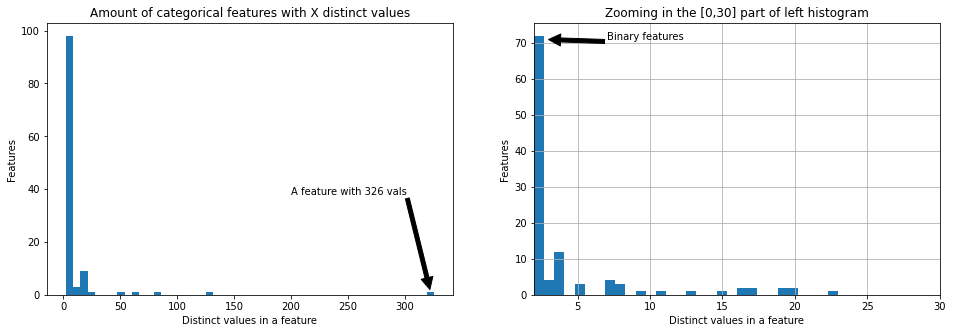

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(uniq_values_in_categories.unique_values, bins=50)
ax1.set_title('Amount of categorical features with X distinct values')
ax1.set_xlabel('Distinct values in a feature')
ax1.set_ylabel('Features')
ax1.annotate('A feature with 326 vals', xy=(322, 2), xytext=(200, 38), arrowprops=dict(facecolor='black'))

ax2.set_xlim(2,30)
ax2.set_title('Zooming in the [0,30] part of left histogram')
ax2.set_xlabel('Distinct values in a feature')
ax2.set_ylabel('Features')
ax2.grid(True)
ax2.hist(uniq_values_in_categories[uniq_values_in_categories.unique_values <= 30].unique_values, bins=30)
ax2.annotate('Binary features', xy=(3, 71), xytext=(7, 71), arrowprops=dict(facecolor='black'))

In [41]:
#正如我们所看到的，大部分的分类特征（72/116）是二值的，绝大多数特征（88/116）有四个值，其中有一个具有326个值的特征

No handles with labels found to put in legend.


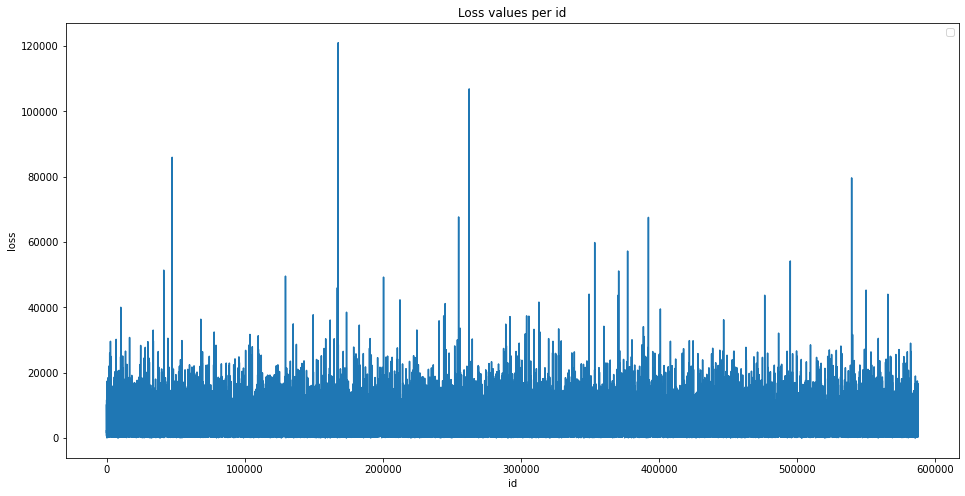

In [42]:
plt.figure(figsize=(16,8))
plt.plot(train['id'], train['loss'])
plt.title('Loss values per id')
plt.xlabel('id')
plt.ylabel('loss')
plt.legend()
plt.show()#赔偿值的分布

<AxesSubplot:xlabel='loss'>

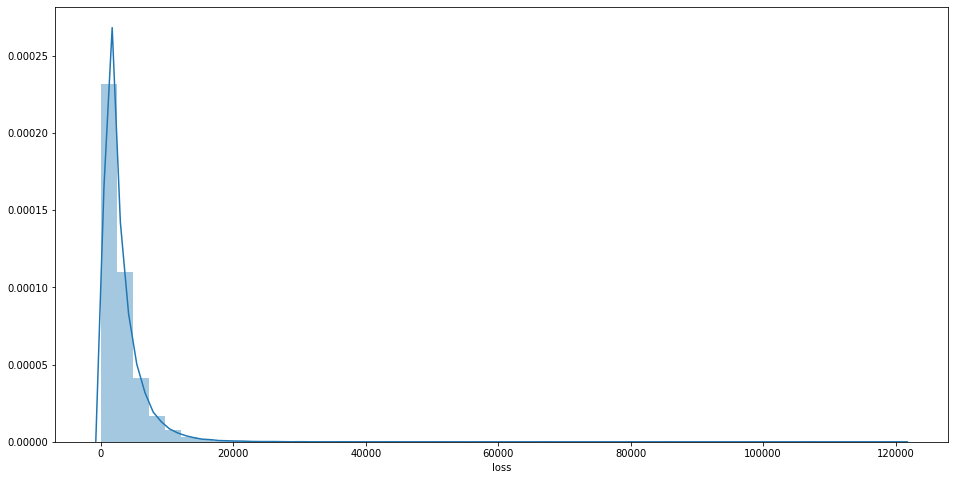

In [44]:
plt.figure(figsize=(16,8))
sns.distplot(train['loss'])

In [45]:
#赔偿值中有几个显著的峰值表示严重事故。这样的数据分布，可能使得这个功能非常扭曲导致的回归表现不佳
#对此，我们要对loss类数据做log变换，使其整体近似于正态分布

<AxesSubplot:xlabel='loss'>

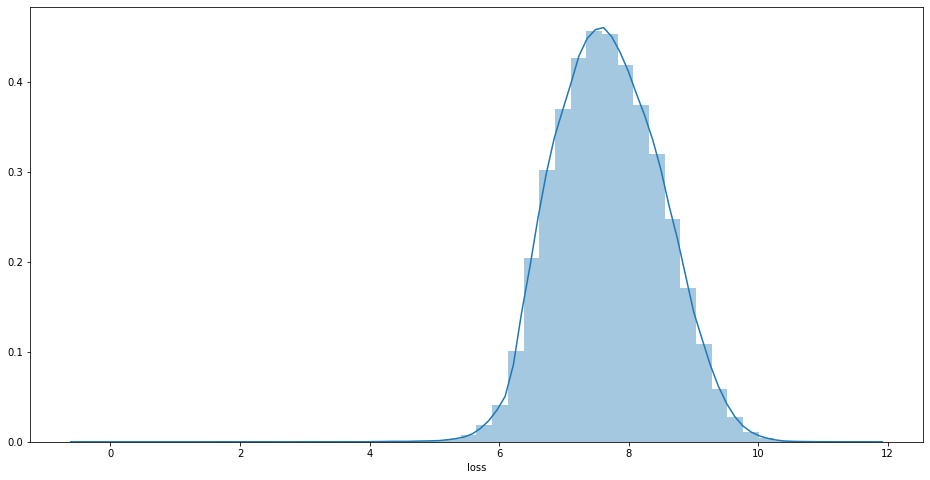

In [48]:
plt.figure(figsize=(16,8))
sns.distplot(train['loss'].apply(lambda x: np.log(x)))

In [49]:
#可见做log变换后我们的数据分布已经比较正常

array([[<AxesSubplot:title={'center':'cont1'}>,
        <AxesSubplot:title={'center':'cont2'}>,
        <AxesSubplot:title={'center':'cont3'}>,
        <AxesSubplot:title={'center':'cont4'}>],
       [<AxesSubplot:title={'center':'cont5'}>,
        <AxesSubplot:title={'center':'cont6'}>,
        <AxesSubplot:title={'center':'cont7'}>,
        <AxesSubplot:title={'center':'cont8'}>],
       [<AxesSubplot:title={'center':'cont9'}>,
        <AxesSubplot:title={'center':'cont10'}>,
        <AxesSubplot:title={'center':'cont11'}>,
        <AxesSubplot:title={'center':'cont12'}>],
       [<AxesSubplot:title={'center':'cont13'}>,
        <AxesSubplot:title={'center':'cont14'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

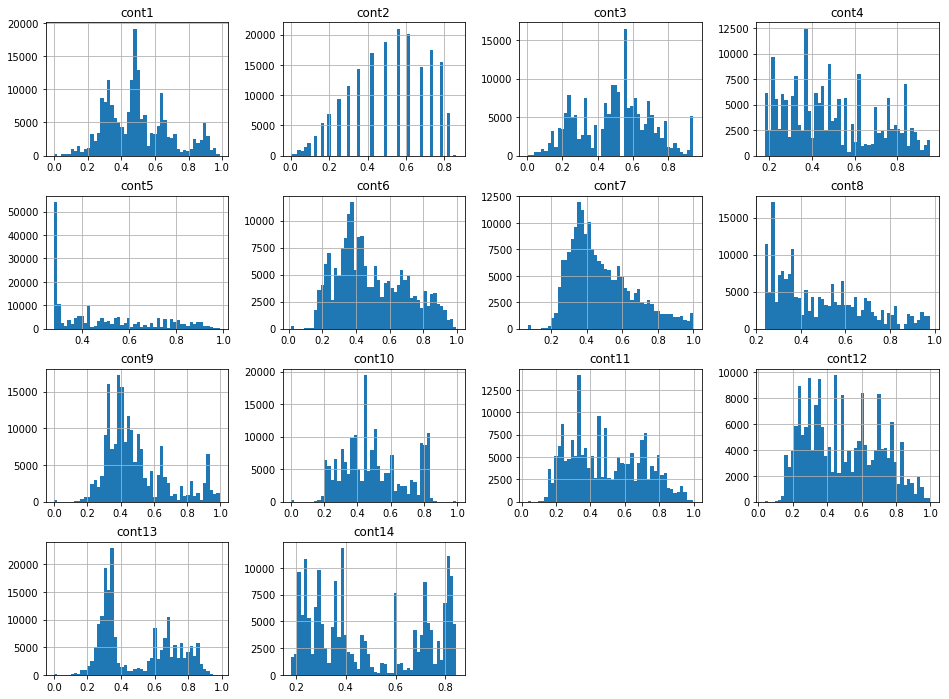

In [50]:
cont_features = [cont for cont in list(train.select_dtypes(
                 include=['float64', 'int64']).columns) if cont not in ['loss', 'id']]
train[cont_features].hist(bins=50, figsize=(16,12))  #连续性数据的分布情况

<AxesSubplot:>

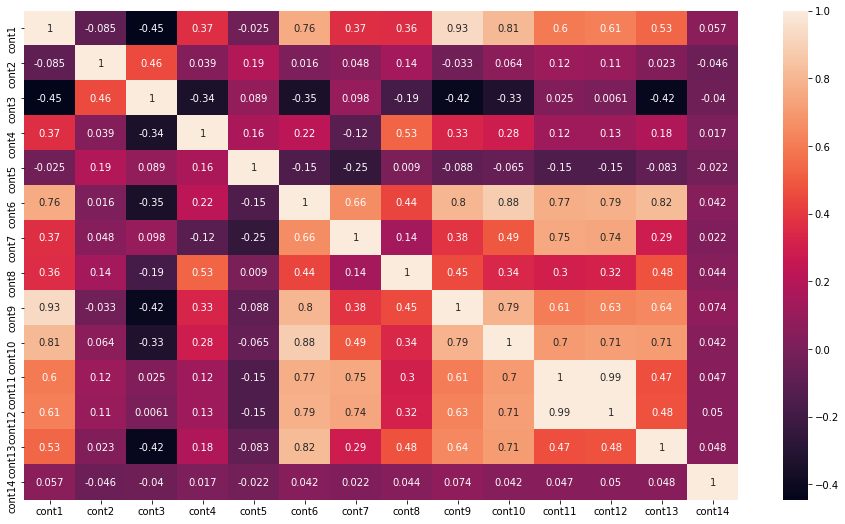

In [51]:
plt.subplots(figsize=(16,9))
correlation_mat = train[cont_features].corr()
sns.heatmap(correlation_mat, annot=True) #热力图查看连续性数据的相关性

特征工程与数据预处理

In [53]:
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import warnings
warnings.filterwarnings('ignore')

In [54]:
train['log_loss'] = np.log(train['loss']) #将标签做对数变换

In [56]:
#数据分成连续和离散特征
features = [x for x in train.columns if x not in ['id','loss', 'log_loss']]

cat_features = [x for x in train.select_dtypes(
        include=['object']).columns if x not in ['id','loss', 'log_loss']]
num_features = [x for x in train.select_dtypes(
        exclude=['object']).columns if x not in ['id','loss', 'log_loss']]

print ("Categorical features:", len(cat_features))
print ("Numerical features:", len(num_features))

Categorical features: 116
Numerical features: 14


In [57]:
ntrain = train.shape[0]

train_x = train[features]
train_y = train['log_loss']

for c in range(len(cat_features)):
    train_x[cat_features[c]] = train_x[cat_features[c]].astype('category').cat.codes
    
print ("Xtrain:", train_x.shape)
print ("ytrain:", train_y.shape)

Xtrain: (188318, 130)
ytrain: (188318,)


In [60]:
#我们先训练一个基本的xgboost模型，然后进行参数调节通过交叉验证来观察结果的变换，使用平均绝对误差来衡量
#xgboost 自定义了一个数据矩阵类 DMatrix，会在训练开始时进行一遍预处理，从而提高之后每次迭代的效率
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

In [61]:
dtrain = xgb.DMatrix(train_x, train['log_loss'])

Xgboost参数如下：
- 'booster':'gbtree',
- 'objective': 'multi:softmax', 多分类的问题
- 'num_class':10, 类别数，与 multisoftmax 并用
- 'gamma':损失下降多少才进行分裂
- 'max_depth':12, 构建树的深度，越大越容易过拟合
- 'lambda':2,  控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
- 'subsample':0.7, 随机采样训练样本
- 'colsample_bytree':0.7, 生成树时进行的列采样
- 'min_child_weight':3, 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束
- 'silent':0 ,设置成1则没有运行信息输出，最好是设置为0.
- 'eta': 0.007, 如同学习率
- 'seed':1000,
- 'nthread':7, cpu 线程数

In [64]:
#定义一个初始参数
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3
}

In [65]:
bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0, 
                feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)#使用交叉验证查看模型效果

print ('CV score:', bst_cv1.iloc[-1,:]['test-mae-mean'])

[19:20:49] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:20:49] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:20:49] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:20:49] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { silent } might not be used

<AxesSubplot:>

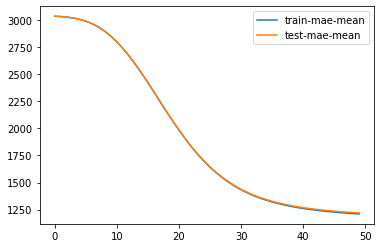

In [66]:

bst_cv1[['train-mae-mean', 'test-mae-mean']].plot()

In [68]:
#可见随着树模型建立的增加损失值越来越低，且没有发生过拟合

In [69]:
#建立100个树模型试试看
bst_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=100, 
                nfold=3, seed=0, feval=xg_eval_mae, maximize=False, 
                early_stopping_rounds=10)

print ('CV score:', bst_cv2.iloc[-1,:]['test-mae-mean'])

[19:25:13] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:13] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:25:13] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:25:13] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { silent } might not be used

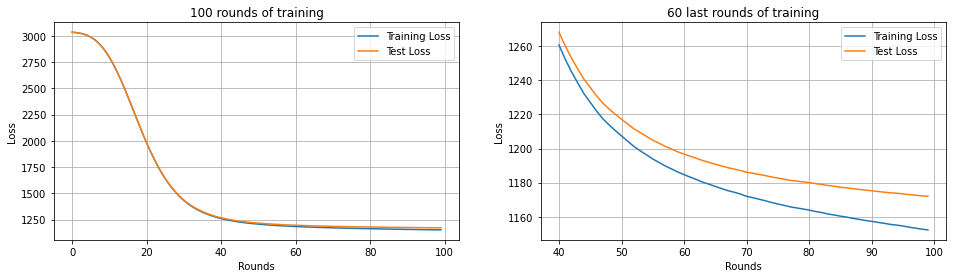

In [70]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean', 'test-mae-mean']])
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Loss', 'Test Loss'])

In [71]:
#可见随着模型数量的增加，出现了一点过拟合，需要通过调其他参数来提升我们的模型了

XGBoost 参数调节
* Step 1: 选择一组初始参数


* Step 2: 改变 `max_depth` 和 `min_child_weight`.


* Step 3: 调节 `gamma` 降低模型过拟合风险.


* Step 4: 调节 `subsample` 和 `colsample_bytree` 改变数据采样策略.


* Step 5: 调节学习率 `eta`.

In [72]:
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})
        
    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, y_train)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self

In [73]:
def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

mae_scorer = make_scorer(mae_score, greater_is_better=False)

In [74]:
bst = XGBoostRegressor(eta=0.1, colsample_bytree=0.5, subsample=0.5, 
                       max_depth=5, min_child_weight=3, num_boost_round=50)

In [75]:
bst.kfold(train_x, train_y, nfold=5)

[19:38:14] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:14] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:38:15] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:15] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost

train-rmse-mean       0.558938
train-rmse-std        0.001005
test-rmse-mean        0.562665
test-rmse-std         0.002445
train-mae-mean     1209.707324
train-mae-std         3.004207
test-mae-mean      1218.884204
test-mae-std          8.982969
Name: 49, dtype: float64

Step 2: 树的深度与节点权重
这些参数对xgboost性能影响最大，因此，他们应该调整第一。我们简要地概述它们：


* `max_depth`: 树的最大深度。增加这个值会使模型更加复杂，也容易出现过拟合，深度3-10是合理的。

* `min_child_weight`: 正则化参数. 如果树分区中的实例权重小于定义的总和，则停止树构建过程。

In [76]:
xgb_param_grid = {'max_depth': list(range(4,9)), 'min_child_weight': list((1,3,6))}
xgb_param_grid['max_depth']

[4, 5, 6, 7, 8]

In [77]:
grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, colsample_bytree=0.5, subsample=0.5),
                param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

[19:41:27] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:41:27] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:41:30] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:41:31] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[19:42:06] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:42:06] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:42:06] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:42:10] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[19:42:48] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:42:49] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:42:49] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:42:53] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[19:43:33] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:34] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:34] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:43:39] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[19:44:25] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:26] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:26] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:44:30] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[19:45:19] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:45:20] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:45:20] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:45:25] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[19:46:17] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:18] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:18] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:46:24] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[19:47:22] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:22] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:22] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:47:28] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x00000203894C4358>,
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 3, 6]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [81]:
grid.best_params_, grid.best_score_

({'max_depth': 8, 'min_child_weight': 6}, -1187.5361109743574)

Step 3: 调节 gamma去降低过拟合风险

In [ ]:
#找到max_depth和min_child_weight的最好参数后，寻找gamma值的最好参数
xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,5)]}

grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.5, subsample=0.5),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

In [104]:
grid.best_params_, grid.best_score_

({'gamma': 0.1}, -1187.0241209800747)

In [106]:
#看来gamma为0.1是最好的

Step 4: 调节样本采样方式 subsample 和 colsample_bytree

In [110]:
xgb_param_grid = {'subsample':[ 0.1 * i for i in range(6,9)],
                      'colsample_bytree':[ 0.1 * i for i in range(6,9)]}


grid = GridSearchCV(XGBoostRegressor(eta=0.1, gamma=0.1, num_boost_round=50, max_depth=8, min_child_weight=6),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
grid.fit(train_x, train_y.values)

[20:18:47] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:47] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:18:54] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:55] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[20:19:59] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:00] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:00] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:20:06] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[20:21:13] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:14] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:14] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:21:21] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[20:22:29] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:29] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:29] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:22:38] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[20:23:56] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:23:57] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:23:57] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:24:04] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x0000020389606128>,
             param_grid={'colsample_bytree': [0.6000000000000001,
                                              0.7000000000000001, 0.8],
                         'subsample': [0.6000000000000001, 0.7000000000000001,
                                       0.8]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [111]:
grid.best_params_, grid.best_score_

({'colsample_bytree': 0.7000000000000001, 'subsample': 0.6000000000000001},
 -1183.0470886163603)

In [112]:
#看来colsample_bytree为0.7，subsample为0.6是最好参数

Step 5: 减小学习率并增大树个数

In [113]:
#参数优化的最后一步是降低学习速度，同时增加更多的估计量

In [114]:
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=50, gamma=0.1, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.7, subsample=0.6),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

[20:30:48] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:30:48] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:30:55] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:30:56] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[20:32:08] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:32:09] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:32:09] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:32:16] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[20:33:30] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:33:30] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:33:30] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:33:38] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[20:34:51] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:51] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:51] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:34:59] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[20:36:10] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:36:11] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:36:11] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:36:18] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x00000203894FD0F0>,
             param_grid={'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04,
                                 0.03]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [115]:
grid.best_params_, grid.best_score_

({'eta': 0.2}, -1165.6315230055752)

In [116]:
#增加树的数量
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=100, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

[20:38:17] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:38:17] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:38:28] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:38:29] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[20:40:09] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:40:10] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:40:10] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:40:20] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[20:42:01] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:42:02] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:42:02] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:42:13] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[20:43:57] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:43:58] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:43:58] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:44:09] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[20:45:54] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:45:55] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:45:55] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:46:05] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x000002038959DE10>,
             param_grid={'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04,
                                 0.03]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [117]:
grid.best_params_, grid.best_score_

({'eta': 0.1}, -1151.624426955283)

In [118]:
#树的数量增加后，学习率低一些的效果更好

In [120]:
xgb_param_grid = {'eta':[0.09,0.08,0.07,0.06,0.05,0.04]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

[20:53:35] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:53:35] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:53:57] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:53:58] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[20:57:19] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:57:20] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:57:20] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:57:41] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[21:01:16] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:17] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:17] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:01:40] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

[21:05:16] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[21:05:17] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[21:05:17] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:05:45] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\objective\regression_obj.cu:168: reg:lin

GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x000002038944F2B0>,
             param_grid={'eta': [0.09, 0.08, 0.07, 0.06, 0.05, 0.04]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [121]:
grid.best_params_, grid.best_score_

({'eta': 0.08}, -1145.8237073269097)

In [122]:
#这是调参好的模型
XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9, eta=0.08)